# Baseline training on content vector data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from seaborn import countplot

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Data loading

In [2]:
# Data paths
CONTENT_VECS = "../../data/intermediary/bert_vecs.npy"
DATA = "../../data/original/Org-Retweeted-Vectors_preproc.csv"

TRAIN = "../../data/intermediary/data_split/train_id_str.txt"
VAL = "../../data/intermediary/data_split/val_id_str.txt"
TEST = "../../data/intermediary/data_split/test_id_str.txt"

In [3]:
with open(CONTENT_VECS, "rb") as f:
    vecs = np.load(f)

In [4]:
vecs.shape

(214670, 768)

In [5]:
data = pd.read_csv(DATA, parse_dates=["created_at"]).iloc[:, 1:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214670 entries, 0 to 214669
Data columns (total 59 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   id_str                                214670 non-null  int64              
 1   created_at                            214670 non-null  datetime64[ns, UTC]
 2   full_text                             214670 non-null  object             
 3   retweet_count                         214670 non-null  float64            
 4   favorite_count                        214670 non-null  float64            
 5   entities.hashtags                     214670 non-null  object             
 6   entities.urls                         214670 non-null  bool               
 7   entities.media                        214670 non-null  bool               
 8   user_id_str                           214670 non-null  int64              
 9   user

In [6]:
with open(TRAIN) as f:
    train_ids = f.read().splitlines()
len(train_ids)

159544

In [7]:
with open(VAL) as f:
    val_ids = f.read().splitlines()
len(val_ids)

19943

In [8]:
with open(TEST) as f:
    test_ids = f.read().splitlines()
len(test_ids)

19944

# Prepare training and validation vectors

In [9]:
data = data.astype({"id_str": str})

In [10]:
data_train = data[data.id_str.isin(train_ids)]
len(data_train)

159544

In [11]:
data_val = data[data.id_str.isin(val_ids)]
len(data_val)

19943

In [12]:
data_test = data[data.id_str.isin(test_ids)]
len(data_test)

19944

In [13]:
train_vecs = vecs[data_train.index.values]
len(train_vecs)

159544

In [14]:
val_vecs = vecs[data_val.index.values]
len(val_vecs)

19943

In [15]:
test_vecs = vecs[data_test.index.values]
len(test_vecs)

19944

# Labels

In [16]:
def retweet_categories(retweet_count):
    if retweet_count == 1:
        return 0
    elif retweet_count >= 2:
        return 1    
    else:
        raise ValueError

data["retweet_label"] = data.retweet_count.map(retweet_categories)

In [17]:
train_labels = data["retweet_label"][data_train.index.values].values
len(train_labels)

159544

In [18]:
val_labels = data["retweet_label"][data_val.index.values].values
len(val_labels)

19943

In [19]:
test_labels = data["retweet_label"][data_test.index.values].values
len(test_labels)

19944

<AxesSubplot:ylabel='Percent'>

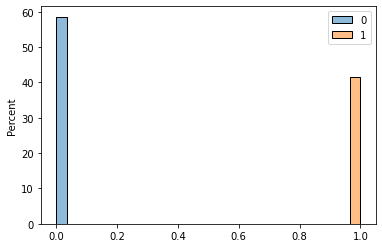

In [20]:
sns.histplot(x=train_labels, hue=train_labels, stat="percent", common_norm=True)

<AxesSubplot:ylabel='count'>

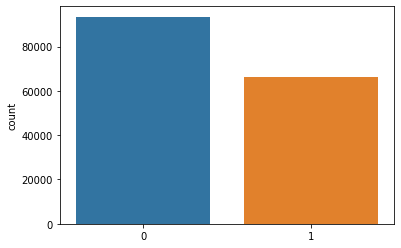

In [21]:
countplot(x=train_labels)

<AxesSubplot:ylabel='Percent'>

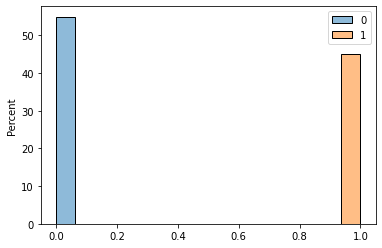

In [22]:
sns.histplot(x=val_labels, hue=val_labels, stat="percent", common_norm=True)

<AxesSubplot:ylabel='count'>

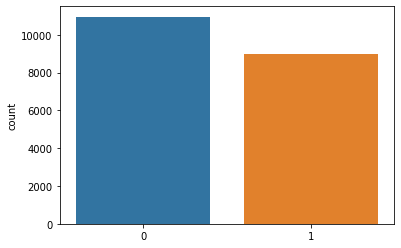

In [23]:
countplot(x=val_labels)

<AxesSubplot:ylabel='Percent'>

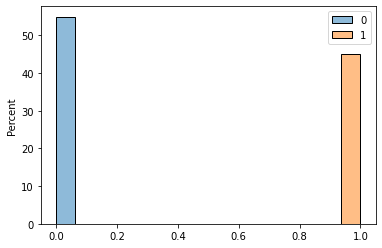

In [24]:
sns.histplot(x=val_labels, hue=val_labels, stat="percent", common_norm=True)

<AxesSubplot:ylabel='count'>

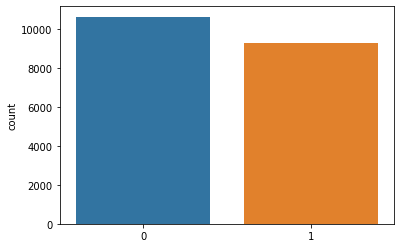

In [25]:
countplot(x=test_labels)

# Simple Training

In [26]:
clf = MLPClassifier(
    max_iter=50,
    hidden_layer_sizes=(512,),
    random_state=1,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    learning_rate_init=0.001,
    batch_size=256)
clf.fit(train_vecs, train_labels)

Iteration 1, loss = 0.64494272
Validation score: 0.633971
Iteration 2, loss = 0.62452472
Validation score: 0.649013
Iteration 3, loss = 0.61421747
Validation score: 0.647446
Iteration 4, loss = 0.60416826
Validation score: 0.649326
Iteration 5, loss = 0.59462241
Validation score: 0.645942
Iteration 6, loss = 0.58303405
Validation score: 0.644563
Iteration 7, loss = 0.56954599
Validation score: 0.639423
Iteration 8, loss = 0.55473120
Validation score: 0.637794
Iteration 9, loss = 0.53623243
Validation score: 0.641116
Iteration 10, loss = 0.51874195
Validation score: 0.634409
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPClassifier(batch_size=256, early_stopping=True, hidden_layer_sizes=(512,),
              max_iter=50, n_iter_no_change=5, random_state=1, verbose=True)

In [27]:
clf.best_validation_score_

0.6493262300219367

In [28]:
clf.score(train_vecs, train_labels)

0.6782580354008926

In [29]:
clf.score(val_vecs, val_labels)

0.6285413428270571

In [30]:
val_predictions = clf.predict(val_vecs)
val_predictions.shape

(19943,)

In [31]:
out = classification_report(val_labels, val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.63      0.76      0.69     10954
           1       0.62      0.46      0.53      8989

    accuracy                           0.63     19943
   macro avg       0.63      0.61      0.61     19943
weighted avg       0.63      0.63      0.62     19943



# Standard scaling

In [32]:
scaler = StandardScaler()

In [33]:
transformed_train_vecs = scaler.fit_transform(train_vecs)

In [34]:
transformed_train_vecs

array([[-0.52097446,  0.26039687, -0.13421221, ..., -0.3979556 ,
        -0.26935866,  0.73173654],
       [-1.3568909 , -0.77428246,  0.7225072 , ...,  0.18733001,
         0.37719136, -0.05505728],
       [ 0.90672433, -0.5945493 ,  0.7991532 , ..., -0.31990397,
        -1.6794659 , -0.029885  ],
       ...,
       [-0.304982  ,  1.7458442 ,  0.18001959, ..., -0.9995774 ,
         0.16209403, -1.7622637 ],
       [-0.7668669 ,  0.83773434,  0.64359844, ..., -1.733119  ,
        -0.4888601 , -0.815279  ],
       [-0.6996573 ,  2.1698804 , -0.63603324, ..., -1.4876254 ,
        -1.5016176 , -2.1676676 ]], dtype=float32)

In [35]:
transformed_val_vecs = scaler.transform(val_vecs)

In [36]:
scaled_clf = MLPClassifier(
    max_iter=50,
    hidden_layer_sizes=(32,),
    random_state=1,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    learning_rate_init=0.001,
    batch_size=32)
scaled_clf.fit(transformed_train_vecs, train_labels)

Iteration 1, loss = 0.65351763
Validation score: 0.631902
Iteration 2, loss = 0.62870588
Validation score: 0.638107
Iteration 3, loss = 0.62192189
Validation score: 0.638170
Iteration 4, loss = 0.61563764
Validation score: 0.635349
Iteration 5, loss = 0.61025550
Validation score: 0.636540
Iteration 6, loss = 0.60546946
Validation score: 0.634723
Iteration 7, loss = 0.60084179
Validation score: 0.637355
Iteration 8, loss = 0.59735627
Validation score: 0.635851
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(32,),
              max_iter=50, n_iter_no_change=5, random_state=1, verbose=True)

In [37]:
scaled_clf.best_validation_score_

0.638169852710749

In [38]:
scaled_clf.score(transformed_train_vecs, train_labels)

0.6594607130321416

In [39]:
scaled_clf.score(transformed_val_vecs, val_labels)

0.6342074913503485

In [40]:
scaled_val_predictions = scaled_clf.predict(transformed_val_vecs)

In [41]:
out = classification_report(val_labels, scaled_val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.64      0.75      0.69     10954
           1       0.62      0.49      0.55      8989

    accuracy                           0.63     19943
   macro avg       0.63      0.62      0.62     19943
weighted avg       0.63      0.63      0.63     19943



In [42]:
scaled_clf_2 = MLPClassifier(
    max_iter=50,
    hidden_layer_sizes=(1000,50,30),
    random_state=1,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    learning_rate_init=0.001,
    batch_size=32)
scaled_clf_2.fit(transformed_train_vecs, train_labels)

Iteration 1, loss = 0.64520964
Validation score: 0.617863
Iteration 2, loss = 0.63292562
Validation score: 0.634848
Iteration 3, loss = 0.62507595
Validation score: 0.634221
Iteration 4, loss = 0.61675415
Validation score: 0.638859
Iteration 5, loss = 0.60883023
Validation score: 0.642432
Iteration 6, loss = 0.59782555
Validation score: 0.641304
Iteration 7, loss = 0.58625879
Validation score: 0.640740
Iteration 8, loss = 0.57201976
Validation score: 0.637355
Iteration 9, loss = 0.55656327
Validation score: 0.636916
Iteration 10, loss = 0.54010992
Validation score: 0.634660
Iteration 11, loss = 0.52297648
Validation score: 0.633971
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPClassifier(batch_size=32, early_stopping=True,
              hidden_layer_sizes=(1000, 50, 30), max_iter=50,
              n_iter_no_change=5, random_state=1, verbose=True)

In [43]:
scaled_clf_2.best_validation_score_

0.6424318395487308

In [44]:
scaled_clf_2.score(transformed_train_vecs, train_labels)

0.6878415985558842

In [45]:
scaled_2_val_predictions = scaled_clf_2.predict(transformed_val_vecs)

In [46]:
out = classification_report(val_labels, scaled_2_val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71     10954
           1       0.65      0.38      0.48      8989

    accuracy                           0.63     19943
   macro avg       0.63      0.61      0.60     19943
weighted avg       0.63      0.63      0.61     19943



# Robust scaler

In [47]:
robust = RobustScaler()
robust_train_vecs = robust.fit_transform(train_vecs)
robust_val_vecs = robust.transform(val_vecs)

In [48]:
robust_clf_1 = MLPClassifier(
    max_iter=50,
    hidden_layer_sizes=(32,),
    random_state=1,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    learning_rate_init=0.001,
    batch_size=32)
robust_clf_1.fit(robust_train_vecs, train_labels)

Iteration 1, loss = 0.64845037
Validation score: 0.632905
Iteration 2, loss = 0.62720299
Validation score: 0.638985
Iteration 3, loss = 0.62009502
Validation score: 0.637418
Iteration 4, loss = 0.61378745
Validation score: 0.638107
Iteration 5, loss = 0.60828161
Validation score: 0.638170
Iteration 6, loss = 0.60312235
Validation score: 0.638295
Iteration 7, loss = 0.59846253
Validation score: 0.638358
Iteration 8, loss = 0.59484401
Validation score: 0.639862
Iteration 9, loss = 0.59183397
Validation score: 0.639611
Iteration 10, loss = 0.58809024
Validation score: 0.640740
Iteration 11, loss = 0.58467693
Validation score: 0.637104
Iteration 12, loss = 0.58135559
Validation score: 0.634409
Iteration 13, loss = 0.57824667
Validation score: 0.633093
Iteration 14, loss = 0.57522510
Validation score: 0.639925
Iteration 15, loss = 0.57295013
Validation score: 0.638483
Iteration 16, loss = 0.56985087
Validation score: 0.635412
Validation score did not improve more than tol=0.000100 for 5 con

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(32,),
              max_iter=50, n_iter_no_change=5, random_state=1, verbose=True)

In [49]:
robust_clf_1.score(robust_train_vecs, train_labels)

0.6895652609938324

In [50]:
robust_clf_1.score(robust_val_vecs, val_labels)

0.6233766233766234

In [51]:
robust_clf_1_val_predictions = robust_clf_1.predict(robust_val_vecs)

In [52]:
out = classification_report(val_labels, robust_clf_1_val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.63      0.78      0.69     10954
           1       0.62      0.43      0.51      8989

    accuracy                           0.62     19943
   macro avg       0.62      0.61      0.60     19943
weighted avg       0.62      0.62      0.61     19943



# Random Forest

In [53]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=0.0001,
    min_samples_leaf=0.0001,
    random_state=1,
    verbose=True,
    n_jobs=-1,
    max_samples=0.4,
    max_features=100,
    oob_score=True,
    class_weight="balanced"    
)

In [54]:
rf.fit(transformed_train_vecs, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=100,
                       max_samples=0.4, min_samples_leaf=0.0001,
                       min_samples_split=0.0001, n_estimators=200, n_jobs=-1,
                       oob_score=True, random_state=1, verbose=True)

In [55]:
rf.score(transformed_val_vecs, val_labels)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


0.6317003459860603

In [56]:
rf.score(transformed_train_vecs, train_labels)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.7s finished


0.8097390061675775

In [57]:
rf_val_predictions = rf.predict(transformed_val_vecs)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


In [58]:
out = classification_report(val_labels, rf_val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.66      0.68      0.67     10954
           1       0.59      0.58      0.59      8989

    accuracy                           0.63     19943
   macro avg       0.63      0.63      0.63     19943
weighted avg       0.63      0.63      0.63     19943



In [59]:
# no scaling (won't influence)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=0.0001,
    min_samples_leaf=0.0001,
    random_state=1,
    verbose=True,
    n_jobs=-1,
    max_samples=0.4,
    max_features=100,
    oob_score=True,
    class_weight="balanced"    
)
rf.fit(train_vecs, train_labels)
out = classification_report(val_labels, rf_val_predictions, output_dict=False)
print(out)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.66      0.68      0.67     10954
           1       0.59      0.58      0.59      8989

    accuracy                           0.63     19943
   macro avg       0.63      0.63      0.63     19943
weighted avg       0.63      0.63      0.63     19943



In [60]:
rf.score(val_vecs, val_labels)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


0.6305972020257734

In [61]:
rf_val_predictions = rf.predict(val_vecs)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


In [62]:
out = classification_report(val_labels, rf_val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.66      0.67      0.67     10954
           1       0.59      0.58      0.59      8989

    accuracy                           0.63     19943
   macro avg       0.63      0.63      0.63     19943
weighted avg       0.63      0.63      0.63     19943



# Dummy classifier

In [63]:
s_dummy = DummyClassifier(strategy="stratified", random_state=1)

In [64]:
s_dummy.fit(train_vecs, train_labels)

DummyClassifier(random_state=1, strategy='stratified')

In [65]:
dummy_val_predictions = s_dummy.predict(val_vecs)

In [66]:
out = classification_report(val_labels, dummy_val_predictions, output_dict=False)
print(out)

              precision    recall  f1-score   support

           0       0.55      0.58      0.56     10954
           1       0.45      0.41      0.43      8989

    accuracy                           0.51     19943
   macro avg       0.50      0.50      0.50     19943
weighted avg       0.50      0.51      0.50     19943

